# Basic semantic segmentation using average unpooling

In [1]:
from PIL import Image
import cPickle as pkl
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.training import moving_averages
import tensorflow as tf
import glob
import os
%matplotlib inline  
print ("Packs loaded.")

Packs loaded.


# Load dataset for semantic segmentation

In [2]:
# Location of the files
camvidpath = 'data/seg/SegNet-Tutorial-master/CamVid/'
# Training data
path1 = os.getcwd() + '/' + camvidpath + 'train/'
path2 = os.getcwd() + '/' + camvidpath + 'trainannot/'
trainimglist = glob.glob(path1 + '/*.png')
trainannotlist = glob.glob(path2 + '/*.png')
print ("%d train images" % (len(trainimglist)))
print ("%d train annotations" % (len(trainannotlist)))

# Test data
path1 = os.getcwd() + '/' + camvidpath + 'test/'
path2 = os.getcwd() + '/' + camvidpath + 'testannot/'
testimglist = glob.glob(path1 + '/*.png')
testannotlist = glob.glob(path2 + '/*.png')
print ("%d test images" % (len(testimglist)))
print ("%d test annotations" % (len(testannotlist)))

367 train images
367 train annotations
233 test images
233 test annotations


# Get train / test images

In [3]:
height = 128
width = 128
nrclass = 22
trainData = None
trainLabel = None
trainLabelOneHot = None
trainlen = len(trainimglist)
testData = None
testLabel = None
testLabelOneHot = None
testlen = len(testimglist)
def DenseToOneHot(labels_dense, num_classes):
    # Convert class labels from scalars to one-hot vectors. 
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot
""" Train data process """ 
for (f1, f2, i) in zip(trainimglist, trainannotlist, range(trainlen)):
    # print ("[%02d/%02d]f1: %sf2: %s" % (i, trainlen, f1, f2))
    # Train image
    img1 = Image.open(f1)
    img1 = img1.resize((height, width))
    rgb  = np.array(img1).reshape(1, height, width, 3)
    # Train label
    img2 = Image.open(f2)
    img2 = img2.resize((height, width), Image.NEAREST)
    label = np.array(img2).reshape(1, height, width, 1)
    # Stack images and labels
    if i == 0: 
        trainData = rgb
        trainLabel = label
    else:
        trainData = np.concatenate((trainData, rgb), axis=0)
        trainLabel = np.concatenate((trainLabel, label), axis=0)
ntrain = len(trainData)
# Onehot-coded label
trainLabelOneHot = np.zeros((trainLabel.shape[0], trainLabel.shape[1]                             , trainLabel.shape[2], nrclass))
for row in range(height):
    for col in range(width):
        single = trainLabel[:, row, col, 0]
        oneHot = DenseToOneHot(single, nrclass) # (367,) => (367, 22)
        trainLabelOneHot[:, row, col, :] = oneHot
print ("Train data process done.")     

""" Test data process """ 
for (f1, f2, i) in zip(testimglist, testannotlist, range(testlen)):
    # print ("[%02d/%02d]f1: %sf2: %s" % (i, testlen, f1, f2))
    # Train image
    img1 = Image.open(f1)
    img1 = img1.resize((height, width))
    rgb  = np.array(img1).reshape(1, height, width, 3)
    # Train label
    img2 = Image.open(f2)
    img2 = img2.resize((height, width), Image.NEAREST)
    label = np.array(img2).reshape(1, height, width, 1)
    # Stack images and labels
    if i == 0: 
        testData = rgb
        testLabel = label
    else:
        testData = np.concatenate((testData, rgb), axis=0)
        testLabel = np.concatenate((testLabel, label), axis=0)
# Onehot-coded label
testLabelOneHot = np.zeros((testLabel.shape[0], testLabel.shape[1], testLabel.shape[2], nrclass))
for row in range(height):
    for col in range(width):
        single = testLabel[:, row, col, 0]
        oneHot = DenseToOneHot(single, nrclass) # (367,) => (367, 22)
        testLabelOneHot[:, row, col, :] = oneHot
print ("Test data process done.")

Train data process done.
Test data process done.


In [4]:
print ("Shape of 'trainData' is %s" % (trainData.shape,))
print ("Shape of 'trainLabel' is %s" % (trainLabel.shape,))
print ("Shape of 'trainLabelOneHot' is %s" % (trainLabelOneHot.shape,))
print ("Shape of 'testData' is %s" % (testData.shape,))
print ("Shape of 'testLabel' is %s" % (testLabel.shape,))
print ("Shape of 'testLabelOneHot' is %s" % (testLabelOneHot.shape,))

Shape of 'trainData' is (367, 128, 128, 3)
Shape of 'trainLabel' is (367, 128, 128, 1)
Shape of 'trainLabelOneHot' is (367, 128, 128, 22)
Shape of 'testData' is (233, 128, 128, 3)
Shape of 'testLabel' is (233, 128, 128, 1)
Shape of 'testLabelOneHot' is (233, 128, 128, 22)


# Define networks

In [5]:
# Define functions
x = tf.placeholder(tf.float32, [None, height, width, 3])
y = tf.placeholder(tf.float32, [None, height, width, nrclass])
keepprob = tf.placeholder(tf.float32)
# Kernels
ksize = 7
fsize = 64
initstdev = 0.1
initfun = tf.random_normal_initializer(mean=0.0, stddev=initstdev)
# initfun = None
weights = {
    'ce1': tf.get_variable("ce1", shape = [ksize, ksize, 3, fsize], initializer = initfun) ,
    'ce2': tf.get_variable("ce2", shape = [ksize, ksize, fsize, fsize], initializer = initfun) ,
    'ce3': tf.get_variable("ce3", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'ce4': tf.get_variable("ce4", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd4': tf.get_variable("cd4", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd3': tf.get_variable("cd3", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd2': tf.get_variable("cd2", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd1': tf.get_variable("cd1", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'dense_inner_prod': tf.get_variable("dense_inner_prod", shape= [1, 1, fsize, nrclass]
                                       , initializer = initfun) # <= 1x1conv
}
biases = {
    'be1': tf.get_variable("be1", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'be2': tf.get_variable("be2", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'be3': tf.get_variable("be3", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'be4': tf.get_variable("be4", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd4': tf.get_variable("bd4", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd3': tf.get_variable("bd3", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd2': tf.get_variable("bd2", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd1': tf.get_variable("bd1", shape = [fsize], initializer = tf.constant_initializer(value=0.0))
}

# DeconvNet model

In [6]:
# input : [m, h, w, c]
def Unpooling(inputOrg, size, mask=None):
    # m, c, h, w order
    m = size[0]
    h = size[1]
    w = size[2]
    c = size[3]
    input = tf.transpose(inputOrg, [0, 3, 1, 2])
    x = tf.reshape(input, [-1, 1])
    k = np.float32(np.array([1.0, 1.0]).reshape([1,-1]))
    output = tf.matmul(x, k)
    output = tf.reshape(output,[-1, c, h, w * 2])
    # m, c, w, h
    xx = tf.transpose(output, [0, 1, 3, 2])
    xx = tf.reshape(xx,[-1, 1])
    output = tf.matmul(xx, k)
    # m, c, w, h
    output = tf.reshape(output, [-1, c, w * 2, h * 2])
    output = tf.transpose(output, [0, 3, 2, 1])
    outshape = tf.pack([m, h * 2, w * 2, c])
    if mask != None:
        dense_mask = tf.sparse_to_dense(mask, outshape, output, 0)
        return output, dense_mask
    else:
        return output

# DeconvNet Model
def Model(_X, _W, _b, _keepprob):
    use_bias = 1
    # Encoder 128x128
    encoder1 = tf.nn.conv2d(_X, _W['ce1'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder1 = tf.nn.bias_add(encoder1, _b['be1'])
    mean, var = tf.nn.moments(encoder1, [0, 1, 2])
    encoder1 = tf.nn.batch_normalization(encoder1, mean, var, 0, 1, 0.0001)
    encoder1 = tf.nn.relu(encoder1)
    encoder1 = tf.nn.max_pool(encoder1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder1 = tf.nn.dropout(encoder1, _keepprob)
    # 64x64
    encoder2 = tf.nn.conv2d(encoder1, _W['ce2'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder2 = tf.nn.bias_add(encoder2, _b['be2'])
    mean, var = tf.nn.moments(encoder1, [0, 1, 2])
    encoder2 = tf.nn.batch_normalization(encoder2, mean, var, 0, 1, 0.0001)
    encoder2 = tf.nn.relu(encoder2)
    encoder2 = tf.nn.max_pool(encoder2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder2 = tf.nn.dropout(encoder2, _keepprob)
    # 32x32
    encoder3 = tf.nn.conv2d(encoder2, _W['ce3'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder3 = tf.nn.bias_add(encoder3, _b['be3'])
    mean, var = tf.nn.moments(encoder3, [0, 1, 2])
    encoder3 = tf.nn.batch_normalization(encoder3, mean, var, 0, 1, 0.0001)
    encoder3 = tf.nn.relu(encoder3)
    encoder3 = tf.nn.max_pool(encoder3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder3 = tf.nn.dropout(encoder3, _keepprob)
    # 16x16
    encoder4 = tf.nn.conv2d(encoder3, _W['ce4'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder4 = tf.nn.bias_add(encoder4, _b['be4'])
    mean, var = tf.nn.moments(encoder4, [0, 1, 2])
    encoder4 = tf.nn.batch_normalization(encoder4, mean, var, 0, 1, 0.0001)
    encoder4 = tf.nn.relu(encoder4)
    encoder4 = tf.nn.max_pool(encoder4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder4 = tf.nn.dropout(encoder4, _keepprob)
    # 8x8

    # Decoder 8x8 (128/16 = 8) fsize: 64
    decoder4 = Unpooling(encoder4, [tf.shape(_X)[0], height / 16, width / 16, fsize])
    decoder4 = tf.nn.conv2d(decoder4, _W['cd4'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder4 = tf.nn.bias_add(decoder4, _b['bd4'])
    mean, var = tf.nn.moments(decoder4, [0, 1, 2])
    decoder4 = tf.nn.batch_normalization(decoder4, mean, var, 0, 1, 0.0001)
    decoder4 = tf.nn.relu(decoder4)
    decoder4 = tf.nn.dropout(decoder4, _keepprob)
    # 16x16
    decoder3 = Unpooling(encoder3, [tf.shape(_X)[0], height/8, width/8, fsize])
    decoder3 = tf.nn.conv2d(decoder3, _W['cd3'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder3 = tf.nn.bias_add(decoder3, _b['bd3'])
    mean, var = tf.nn.moments(decoder3, [0, 1, 2])
    decoder3 = tf.nn.batch_normalization(decoder3, mean, var, 0, 1, 0.0001)
    decoder3 = tf.nn.relu(decoder3)
    decoder3 = tf.nn.dropout(decoder3, _keepprob)
    # 32x32
    decoder2 = Unpooling(decoder3, [tf.shape(_X)[0], height/4, width/4, fsize])
    decoder2 = tf.nn.conv2d(decoder2, _W['cd2'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder2 = tf.nn.bias_add(decoder2, _b['bd2'])
    mean, var = tf.nn.moments(decoder2, [0, 1, 2])
    decoder2 = tf.nn.batch_normalization(decoder2, mean, var, 0, 1, 0.0001)
    decoder2 = tf.nn.relu(decoder2)
    decoder2 = tf.nn.dropout(decoder2, _keepprob)
    # 64x64
    decoder1 = Unpooling(decoder2, [tf.shape(_X)[0], height / 2, width / 2, fsize])
    decoder1 = tf.nn.conv2d(decoder1, _W['cd1'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder1 = tf.nn.bias_add(decoder1, _b['bd1'])
    mean, var = tf.nn.moments(decoder1, [0, 1, 2])
    decoder1 = tf.nn.batch_normalization(decoder1, mean, var, 0, 1, 0.0001)
    decoder1 = tf.nn.relu(decoder1)
    decoder1 = tf.nn.dropout(decoder1, _keepprob)
    # 128x128
    output = tf.nn.conv2d(decoder1, _W['dense_inner_prod'], strides=[1, 1, 1, 1], padding='SAME')
    return output

print ("Network ready")

Network ready


# Define functions

In [ ]:
pred = Model(x, weights, biases, keepprob)
lin_pred = tf.reshape(pred, shape=[-1, nrclass])
lin_y = tf.reshape(y, shape=[-1, nrclass])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(lin_pred, lin_y))
# Class label
predmax = tf.argmax(pred, 3)
ymax = tf.argmax(y, 3)
# Accuracy
corr = tf.equal(tf.argmax(y,3), tf.argmax(pred, 3)) 
accr = tf.reduce_mean(tf.cast(corr, "float"))
# Optimizer
optm = tf.train.AdamOptimizer(0.0001).minimize(cost)
batch_size = 128
n_epochs = 1000

print ("Functions ready")

Functions ready


# Real optimization starts here

checkpoint: None
Couldn't find checkpoint to restore from. Starting over.
[00/1000] trainLoss: 2.9553 trainAcc: 0.12 valLoss: 2.9102 valAcc: 0.15


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


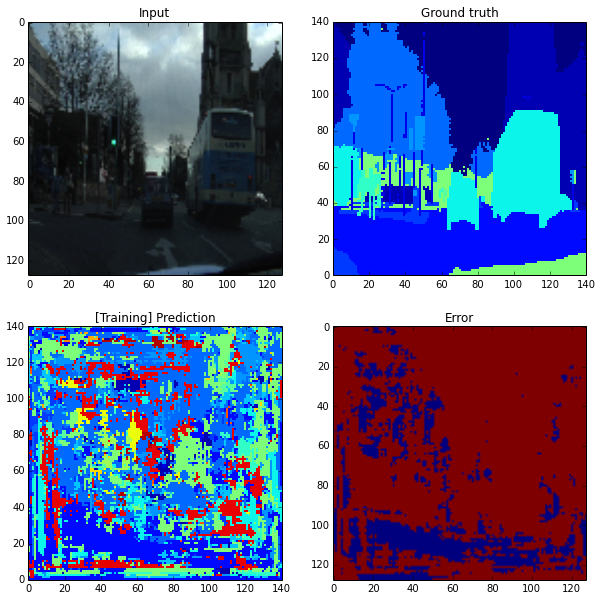

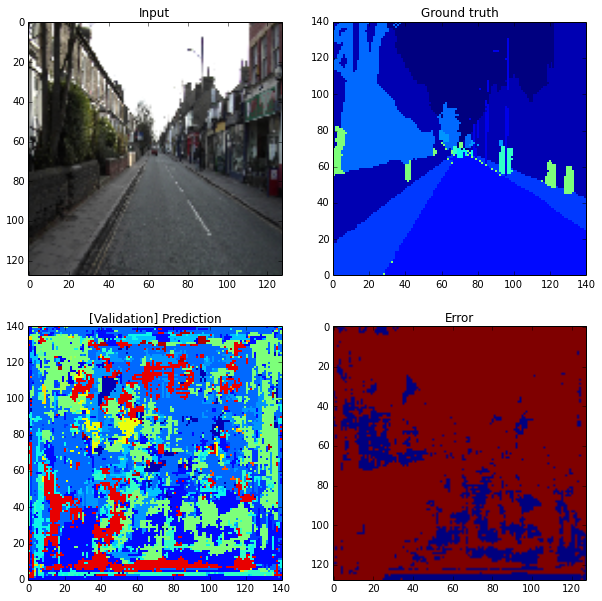

[01/1000] trainLoss: 2.8070 trainAcc: 0.20 valLoss: 2.7921 valAcc: 0.22
[02/1000] trainLoss: 2.7009 trainAcc: 0.26 valLoss: 2.6881 valAcc: 0.27
[03/1000] trainLoss: 2.5958 trainAcc: 0.30 valLoss: 2.5921 valAcc: 0.30
[04/1000] trainLoss: 2.5154 trainAcc: 0.33 valLoss: 2.5097 valAcc: 0.33
[05/1000] trainLoss: 2.4184 trainAcc: 0.38 valLoss: 2.4412 valAcc: 0.34
[06/1000] trainLoss: 2.3440 trainAcc: 0.40 valLoss: 2.3827 valAcc: 0.36
[07/1000] trainLoss: 2.2839 trainAcc: 0.42 valLoss: 2.3297 valAcc: 0.38
[08/1000] trainLoss: 2.2152 trainAcc: 0.44 valLoss: 2.2804 valAcc: 0.39
[09/1000] trainLoss: 2.1639 trainAcc: 0.46 valLoss: 2.2338 valAcc: 0.41
[10/1000] trainLoss: 2.0765 trainAcc: 0.49 valLoss: 2.1936 valAcc: 0.43


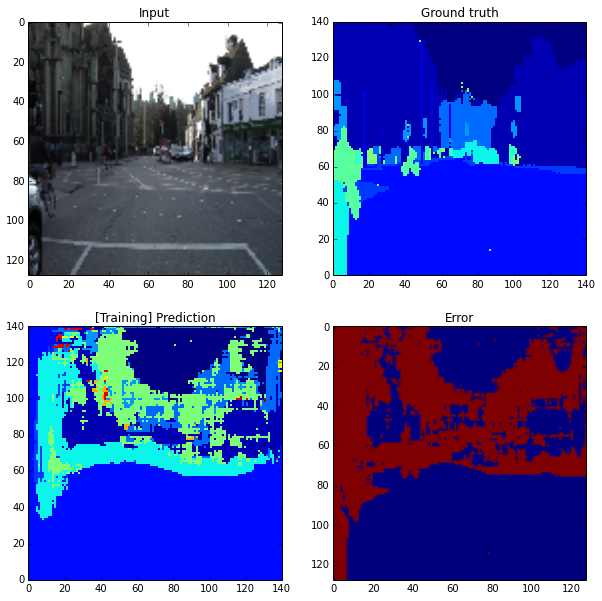

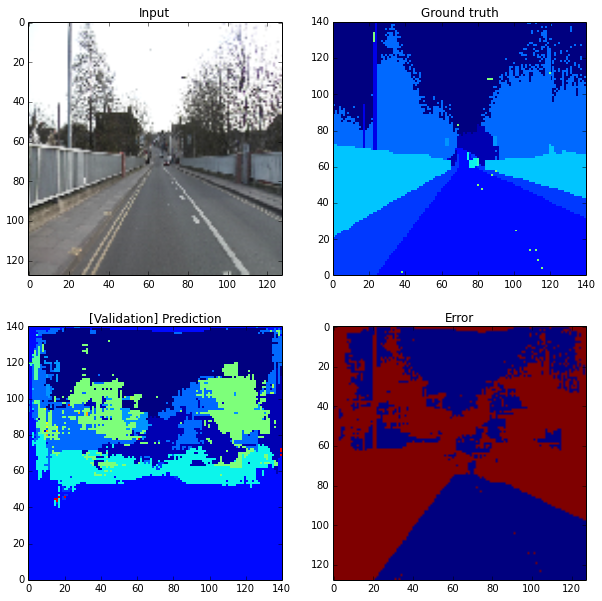

[11/1000] trainLoss: 2.0611 trainAcc: 0.50 valLoss: 2.1583 valAcc: 0.45
[12/1000] trainLoss: 2.0091 trainAcc: 0.52 valLoss: 2.1290 valAcc: 0.47
[13/1000] trainLoss: 1.9566 trainAcc: 0.55 valLoss: 2.1042 valAcc: 0.49
[14/1000] trainLoss: 1.9453 trainAcc: 0.55 valLoss: 2.0781 valAcc: 0.50
[15/1000] trainLoss: 1.8994 trainAcc: 0.58 valLoss: 2.0523 valAcc: 0.52
[16/1000] trainLoss: 1.8769 trainAcc: 0.59 valLoss: 2.0235 valAcc: 0.53
[17/1000] trainLoss: 1.8219 trainAcc: 0.62 valLoss: 1.9962 valAcc: 0.54
[18/1000] trainLoss: 1.8140 trainAcc: 0.62 valLoss: 1.9747 valAcc: 0.54
[19/1000] trainLoss: 1.7699 trainAcc: 0.63 valLoss: 1.9559 valAcc: 0.54
[20/1000] trainLoss: 1.7668 trainAcc: 0.64 valLoss: 1.9350 valAcc: 0.55


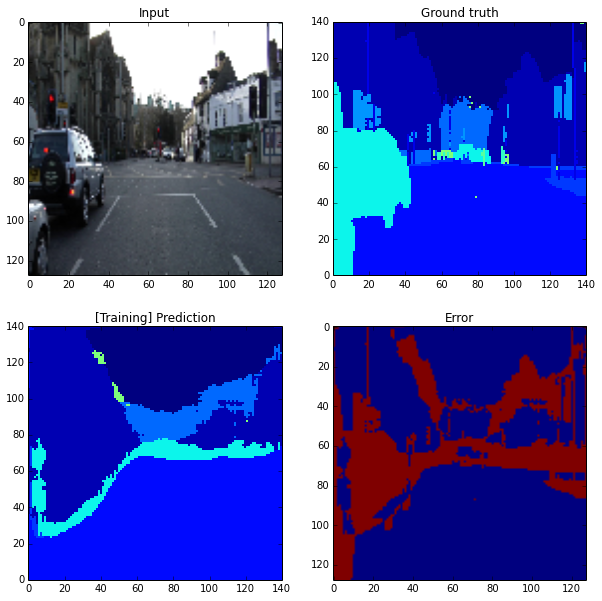

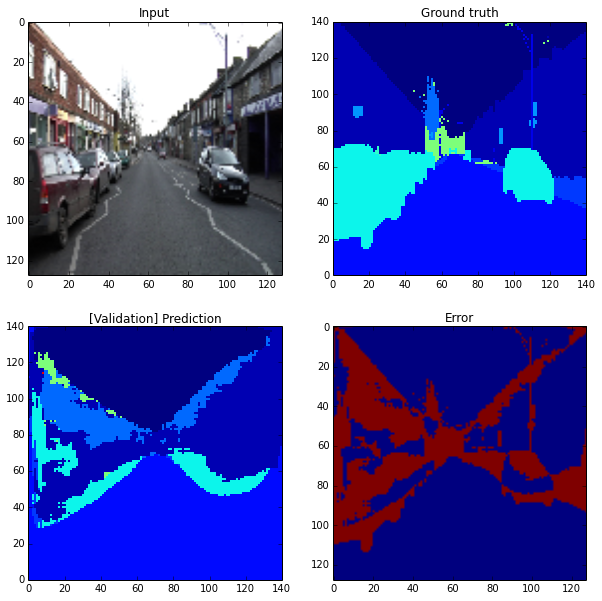

[21/1000] trainLoss: 1.7283 trainAcc: 0.65 valLoss: 1.9152 valAcc: 0.55
[22/1000] trainLoss: 1.7069 trainAcc: 0.66 valLoss: 1.8951 valAcc: 0.56
[23/1000] trainLoss: 1.6905 trainAcc: 0.66 valLoss: 1.8765 valAcc: 0.56
[24/1000] trainLoss: 1.6775 trainAcc: 0.65 valLoss: 1.8582 valAcc: 0.56
[25/1000] trainLoss: 1.6549 trainAcc: 0.66 valLoss: 1.8417 valAcc: 0.57
[26/1000] trainLoss: 1.6360 trainAcc: 0.66 valLoss: 1.8246 valAcc: 0.57
[27/1000] trainLoss: 1.6135 trainAcc: 0.67 valLoss: 1.8104 valAcc: 0.57
[28/1000] trainLoss: 1.5975 trainAcc: 0.67 valLoss: 1.7977 valAcc: 0.58
[29/1000] trainLoss: 1.5877 trainAcc: 0.67 valLoss: 1.7825 valAcc: 0.58
[30/1000] trainLoss: 1.5641 trainAcc: 0.67 valLoss: 1.7681 valAcc: 0.58


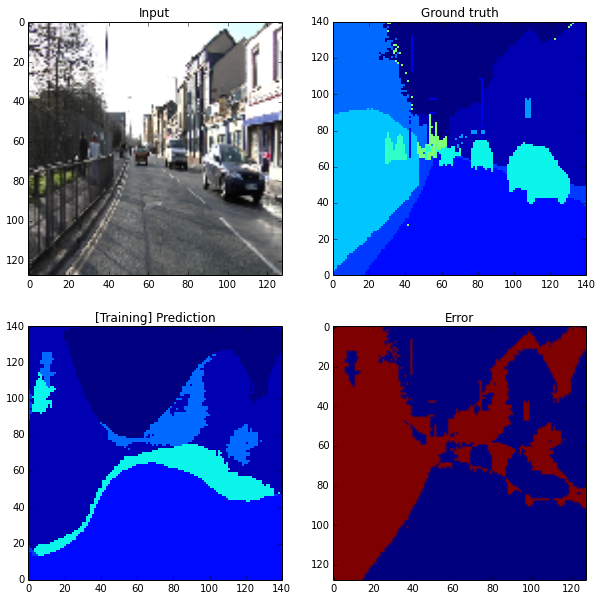

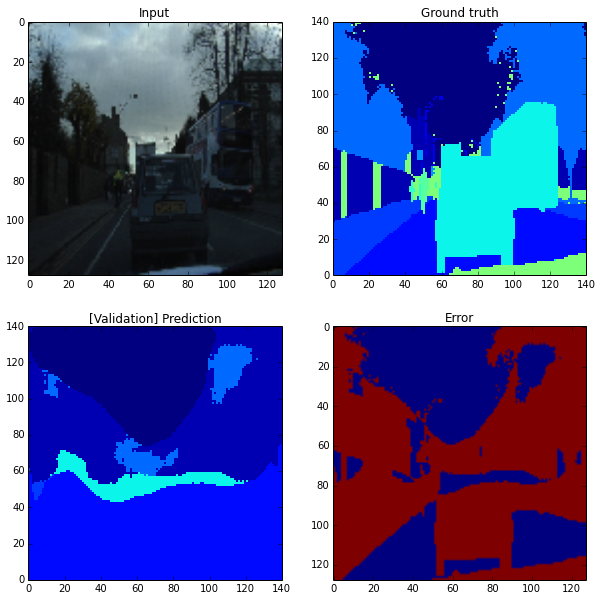

[31/1000] trainLoss: 1.5504 trainAcc: 0.67 valLoss: 1.7532 valAcc: 0.58
[32/1000] trainLoss: 1.5248 trainAcc: 0.68 valLoss: 1.7531 valAcc: 0.58
[33/1000] trainLoss: 1.5287 trainAcc: 0.67 valLoss: 1.7423 valAcc: 0.58
[34/1000] trainLoss: 1.5186 trainAcc: 0.68 valLoss: 1.7166 valAcc: 0.59
[35/1000] trainLoss: 1.5014 trainAcc: 0.68 valLoss: 1.7099 valAcc: 0.59
[36/1000] trainLoss: 1.4851 trainAcc: 0.68 valLoss: 1.7123 valAcc: 0.58
[37/1000] trainLoss: 1.4828 trainAcc: 0.68 valLoss: 1.6960 valAcc: 0.59
[38/1000] trainLoss: 1.4726 trainAcc: 0.68 valLoss: 1.6817 valAcc: 0.59
[39/1000] trainLoss: 1.4559 trainAcc: 0.68 valLoss: 1.6794 valAcc: 0.59
[40/1000] trainLoss: 1.4469 trainAcc: 0.68 valLoss: 1.6666 valAcc: 0.59


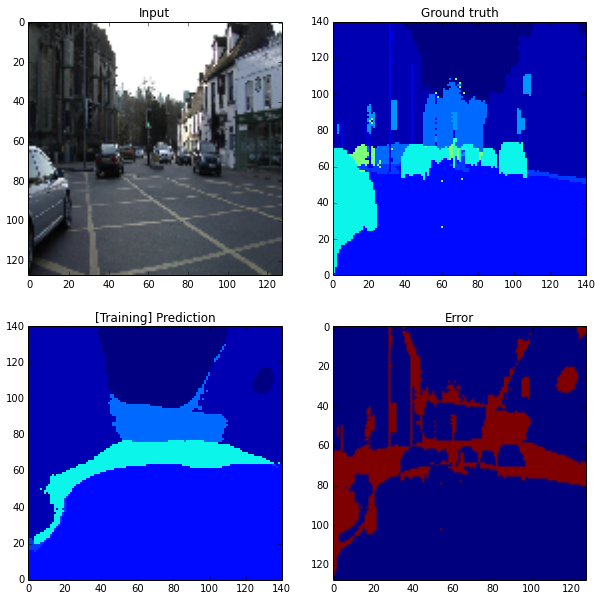

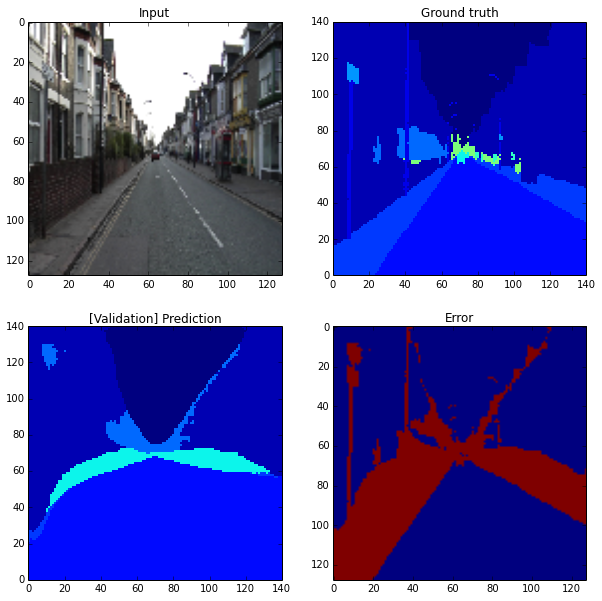

[41/1000] trainLoss: 1.4369 trainAcc: 0.68 valLoss: 1.6507 valAcc: 0.59
[42/1000] trainLoss: 1.4286 trainAcc: 0.69 valLoss: 1.6477 valAcc: 0.59
[43/1000] trainLoss: 1.4231 trainAcc: 0.68 valLoss: 1.6483 valAcc: 0.59
[44/1000] trainLoss: 1.4377 trainAcc: 0.68 valLoss: 1.6295 valAcc: 0.59
[45/1000] trainLoss: 1.3890 trainAcc: 0.69 valLoss: 1.6143 valAcc: 0.59
[46/1000] trainLoss: 1.3901 trainAcc: 0.69 valLoss: 1.6183 valAcc: 0.59
[47/1000] trainLoss: 1.3789 trainAcc: 0.69 valLoss: 1.6063 valAcc: 0.59
[48/1000] trainLoss: 1.3752 trainAcc: 0.69 valLoss: 1.5919 valAcc: 0.59
[49/1000] trainLoss: 1.3684 trainAcc: 0.69 valLoss: 1.5862 valAcc: 0.59
[50/1000] trainLoss: 1.3560 trainAcc: 0.69 valLoss: 1.5823 valAcc: 0.59


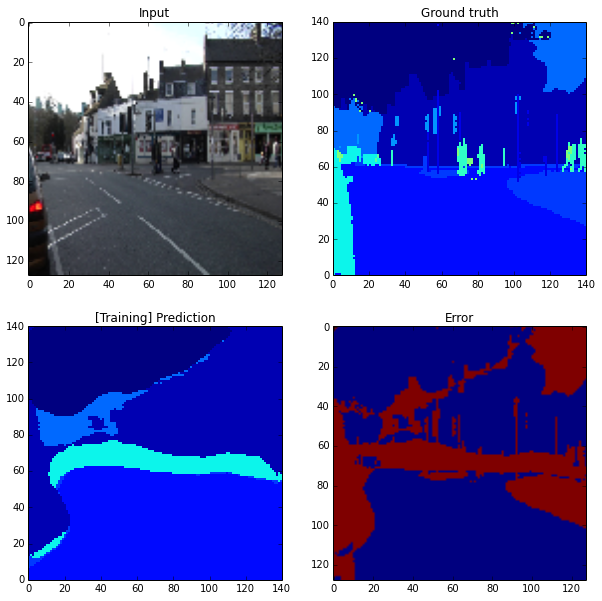

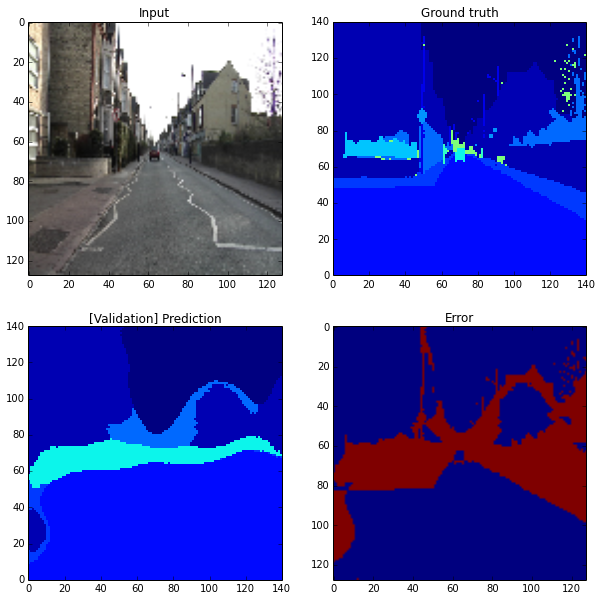

[51/1000] trainLoss: 1.3348 trainAcc: 0.70 valLoss: 1.5757 valAcc: 0.59
[52/1000] trainLoss: 1.3387 trainAcc: 0.70 valLoss: 1.5618 valAcc: 0.59
[53/1000] trainLoss: 1.3152 trainAcc: 0.71 valLoss: 1.5608 valAcc: 0.59
[54/1000] trainLoss: 1.3453 trainAcc: 0.69 valLoss: 1.5517 valAcc: 0.60
[55/1000] trainLoss: 1.3170 trainAcc: 0.70 valLoss: 1.5366 valAcc: 0.60
[56/1000] trainLoss: 1.3041 trainAcc: 0.70 valLoss: 1.5394 valAcc: 0.60
[57/1000] trainLoss: 1.3118 trainAcc: 0.70 valLoss: 1.5164 valAcc: 0.60
[58/1000] trainLoss: 1.2901 trainAcc: 0.70 valLoss: 1.5190 valAcc: 0.60
[59/1000] trainLoss: 1.2847 trainAcc: 0.71 valLoss: 1.5089 valAcc: 0.60
[60/1000] trainLoss: 1.2574 trainAcc: 0.72 valLoss: 1.4875 valAcc: 0.61


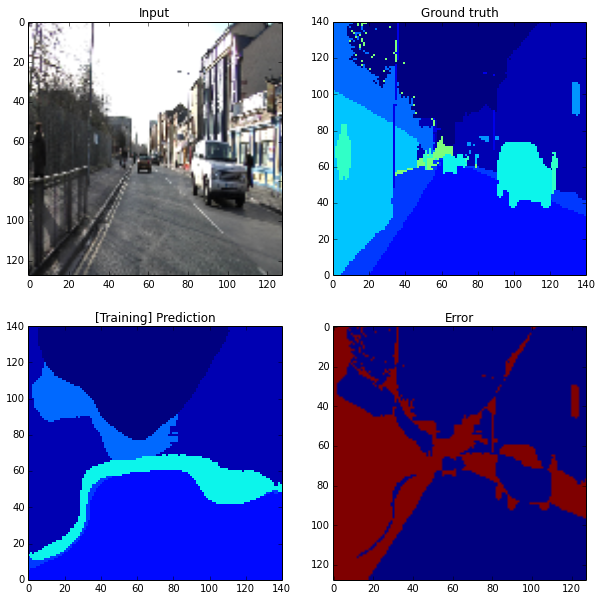

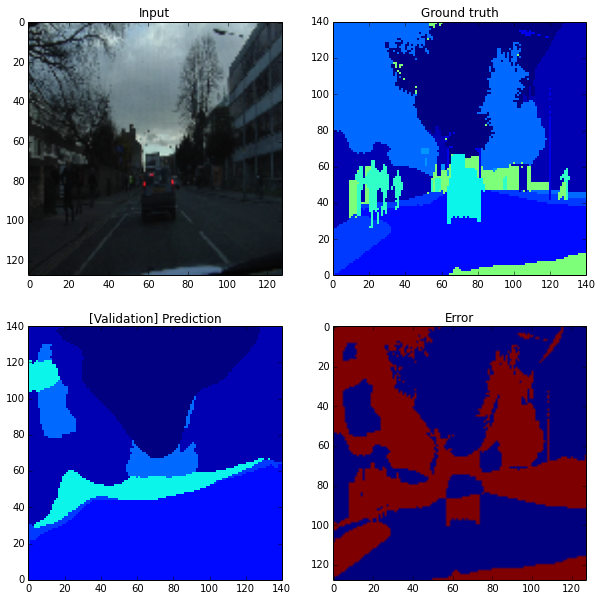

[61/1000] trainLoss: 1.2585 trainAcc: 0.71 valLoss: 1.4912 valAcc: 0.61
[62/1000] trainLoss: 1.2675 trainAcc: 0.71 valLoss: 1.4793 valAcc: 0.61
[63/1000] trainLoss: 1.2408 trainAcc: 0.72 valLoss: 1.4812 valAcc: 0.61
[64/1000] trainLoss: 1.2612 trainAcc: 0.71 valLoss: 1.4660 valAcc: 0.61
[65/1000] trainLoss: 1.2294 trainAcc: 0.72 valLoss: 1.4551 valAcc: 0.61
[66/1000] trainLoss: 1.2306 trainAcc: 0.72 valLoss: 1.4502 valAcc: 0.62
[67/1000] trainLoss: 1.2088 trainAcc: 0.73 valLoss: 1.4344 valAcc: 0.62
[68/1000] trainLoss: 1.2013 trainAcc: 0.73 valLoss: 1.4429 valAcc: 0.62
[69/1000] trainLoss: 1.1973 trainAcc: 0.73 valLoss: 1.4311 valAcc: 0.62
[70/1000] trainLoss: 1.1683 trainAcc: 0.74 valLoss: 1.4179 valAcc: 0.63


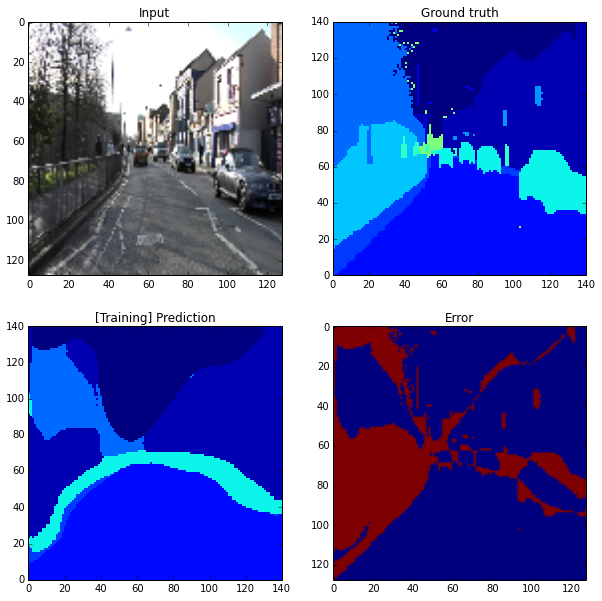

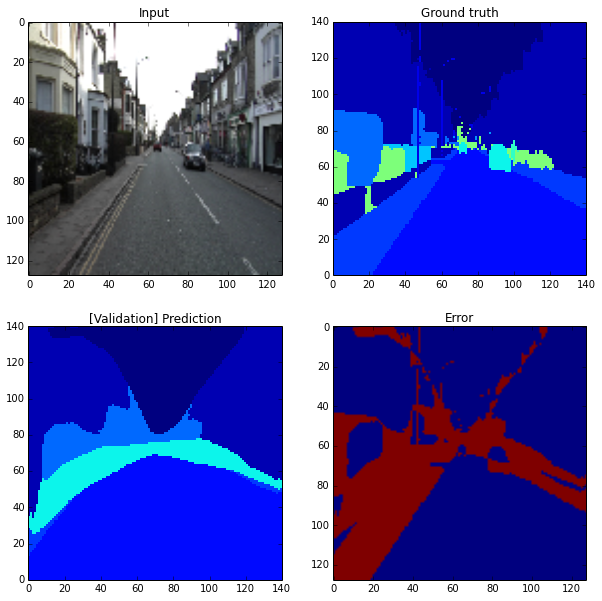

[71/1000] trainLoss: 1.1730 trainAcc: 0.74 valLoss: 1.4021 valAcc: 0.63
[72/1000] trainLoss: 1.1663 trainAcc: 0.74 valLoss: 1.3948 valAcc: 0.63
[73/1000] trainLoss: 1.1785 trainAcc: 0.73 valLoss: 1.3994 valAcc: 0.63
[74/1000] trainLoss: 1.1793 trainAcc: 0.73 valLoss: 1.3786 valAcc: 0.64
[75/1000] trainLoss: 1.1495 trainAcc: 0.74 valLoss: 1.3626 valAcc: 0.65
[76/1000] trainLoss: 1.1469 trainAcc: 0.74 valLoss: 1.3470 valAcc: 0.65
[77/1000] trainLoss: 1.1306 trainAcc: 0.75 valLoss: 1.3551 valAcc: 0.65
[78/1000] trainLoss: 1.1191 trainAcc: 0.75 valLoss: 1.3432 valAcc: 0.65
[79/1000] trainLoss: 1.0975 trainAcc: 0.76 valLoss: 1.3357 valAcc: 0.66
[80/1000] trainLoss: 1.1119 trainAcc: 0.75 valLoss: 1.3146 valAcc: 0.66


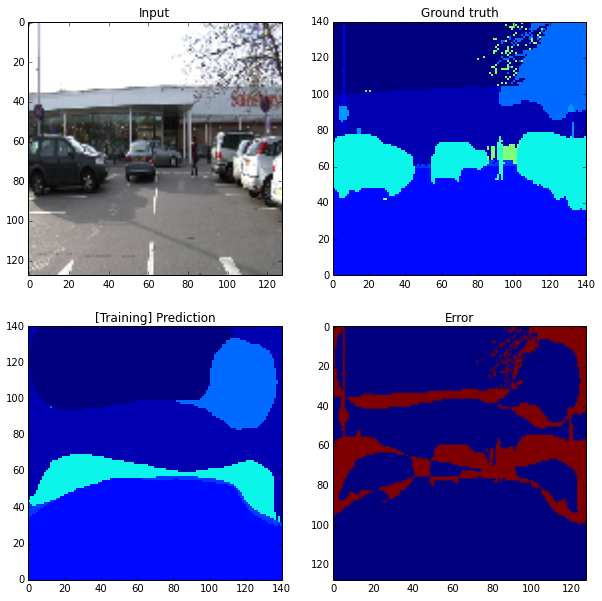

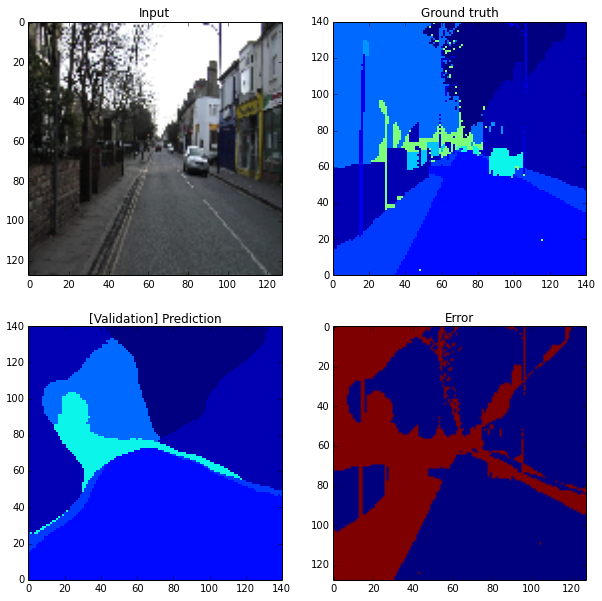

[81/1000] trainLoss: 1.1025 trainAcc: 0.75 valLoss: 1.3332 valAcc: 0.65
[82/1000] trainLoss: 1.1168 trainAcc: 0.75 valLoss: 1.3288 valAcc: 0.66
[83/1000] trainLoss: 1.0814 trainAcc: 0.76 valLoss: 1.2999 valAcc: 0.66
[84/1000] trainLoss: 1.1020 trainAcc: 0.75 valLoss: 1.3221 valAcc: 0.66
[85/1000] trainLoss: 1.0831 trainAcc: 0.75 valLoss: 1.3084 valAcc: 0.66
[86/1000] trainLoss: 1.0746 trainAcc: 0.76 valLoss: 1.2929 valAcc: 0.66
[87/1000] trainLoss: 1.0544 trainAcc: 0.76 valLoss: 1.2994 valAcc: 0.66
[88/1000] trainLoss: 1.0681 trainAcc: 0.76 valLoss: 1.2893 valAcc: 0.66
[89/1000] trainLoss: 1.0638 trainAcc: 0.76 valLoss: 1.2938 valAcc: 0.66
[90/1000] trainLoss: 1.0649 trainAcc: 0.76 valLoss: 1.2784 valAcc: 0.67


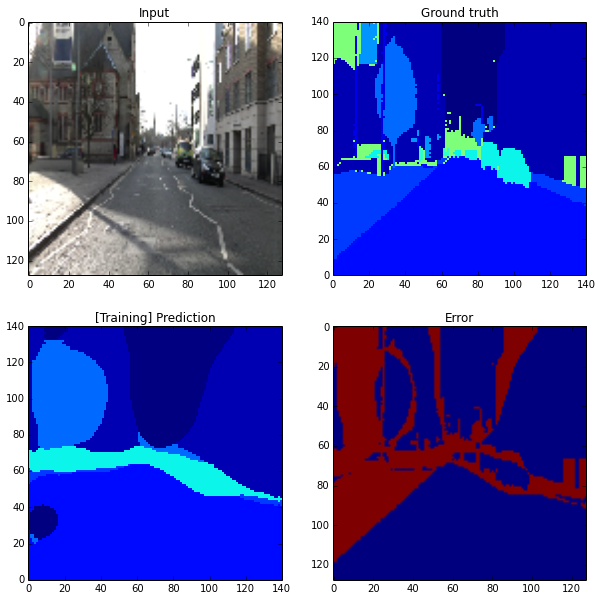

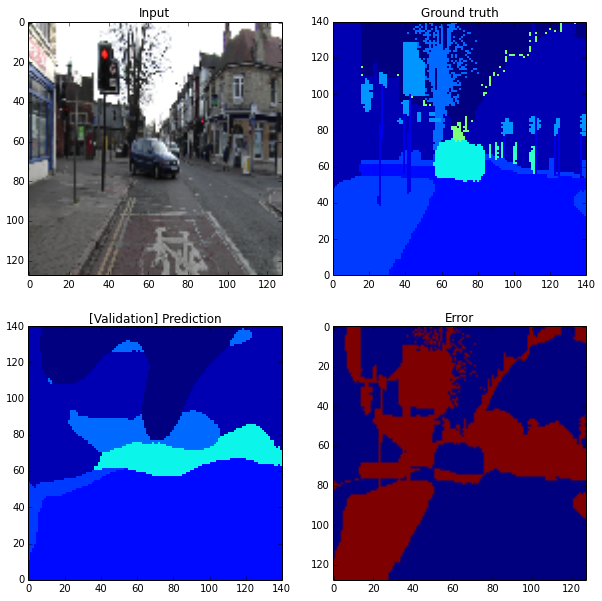

[91/1000] trainLoss: 1.0376 trainAcc: 0.77 valLoss: 1.2737 valAcc: 0.67
[92/1000] trainLoss: 1.0581 trainAcc: 0.76 valLoss: 1.2654 valAcc: 0.67
[93/1000] trainLoss: 1.0369 trainAcc: 0.76 valLoss: 1.2588 valAcc: 0.67
[94/1000] trainLoss: 1.0324 trainAcc: 0.77 valLoss: 1.2727 valAcc: 0.67
[95/1000] trainLoss: 1.0431 trainAcc: 0.76 valLoss: 1.2844 valAcc: 0.66
[96/1000] trainLoss: 1.0325 trainAcc: 0.77 valLoss: 1.2453 valAcc: 0.67
[97/1000] trainLoss: 1.0197 trainAcc: 0.77 valLoss: 1.2425 valAcc: 0.67
[98/1000] trainLoss: 1.0132 trainAcc: 0.77 valLoss: 1.2555 valAcc: 0.67
[99/1000] trainLoss: 1.0214 trainAcc: 0.77 valLoss: 1.2477 valAcc: 0.67
[100/1000] trainLoss: 1.0075 trainAcc: 0.77 valLoss: 1.2333 valAcc: 0.67


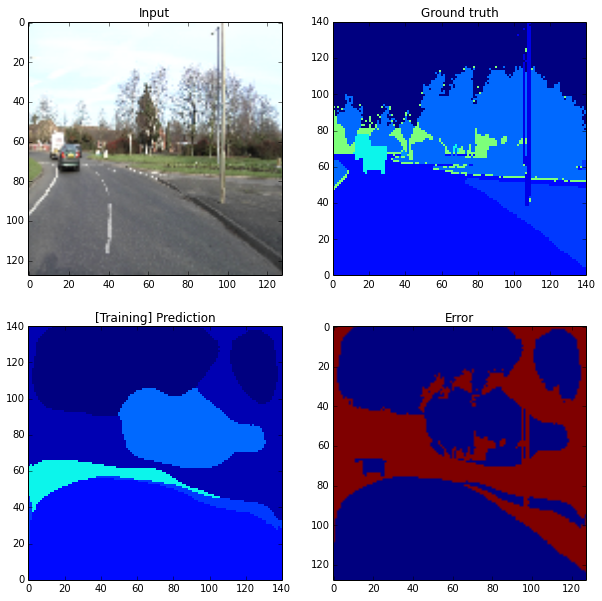

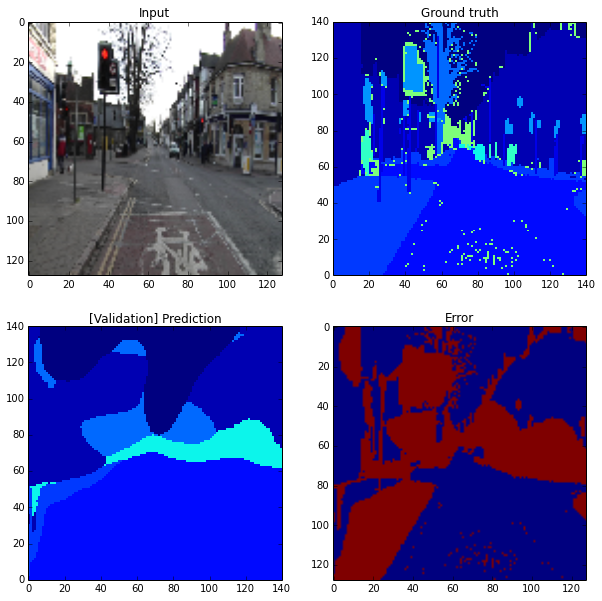

[101/1000] trainLoss: 0.9897 trainAcc: 0.78 valLoss: 1.2337 valAcc: 0.67
[102/1000] trainLoss: 0.9905 trainAcc: 0.78 valLoss: 1.2234 valAcc: 0.68
[103/1000] trainLoss: 0.9844 trainAcc: 0.77 valLoss: 1.2366 valAcc: 0.67
[104/1000] trainLoss: 0.9953 trainAcc: 0.77 valLoss: 1.2190 valAcc: 0.68
[105/1000] trainLoss: 1.0134 trainAcc: 0.76 valLoss: 1.2159 valAcc: 0.68
[106/1000] trainLoss: 0.9992 trainAcc: 0.77 valLoss: 1.2267 valAcc: 0.67
[107/1000] trainLoss: 0.9795 trainAcc: 0.77 valLoss: 1.1985 valAcc: 0.68
[108/1000] trainLoss: 0.9919 trainAcc: 0.77 valLoss: 1.2004 valAcc: 0.68
[109/1000] trainLoss: 0.9664 trainAcc: 0.78 valLoss: 1.2066 valAcc: 0.68
[110/1000] trainLoss: 0.9643 trainAcc: 0.78 valLoss: 1.2102 valAcc: 0.68


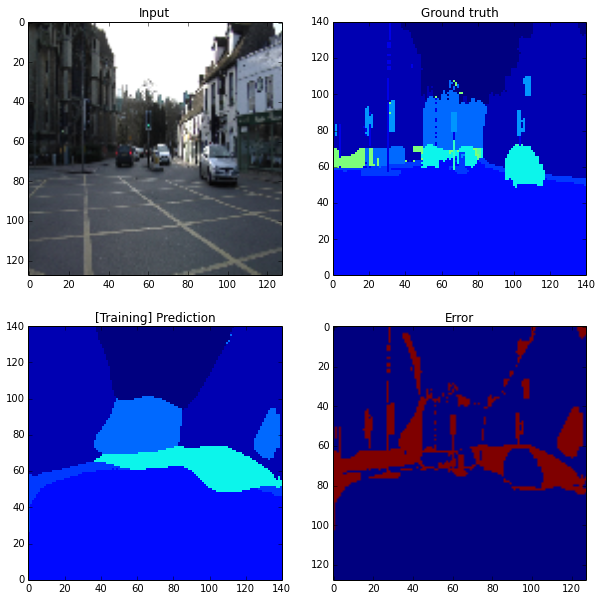

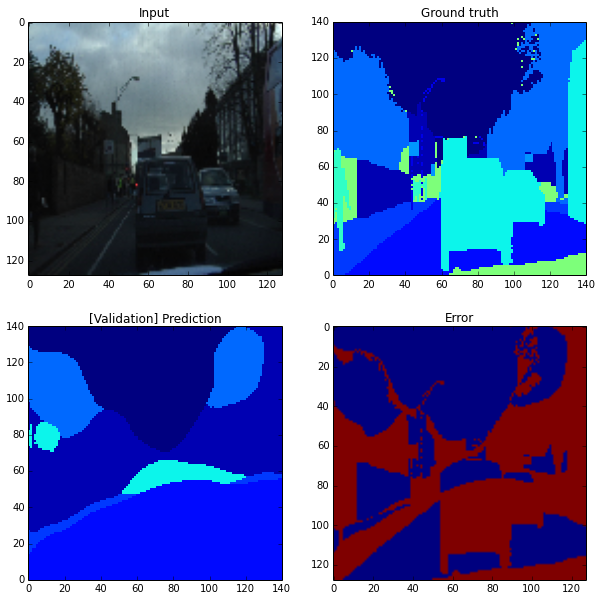

[111/1000] trainLoss: 0.9611 trainAcc: 0.78 valLoss: 1.1892 valAcc: 0.68
[112/1000] trainLoss: 0.9450 trainAcc: 0.78 valLoss: 1.1929 valAcc: 0.68
[113/1000] trainLoss: 0.9452 trainAcc: 0.78 valLoss: 1.1849 valAcc: 0.68
[114/1000] trainLoss: 0.9561 trainAcc: 0.78 valLoss: 1.1759 valAcc: 0.68
[115/1000] trainLoss: 0.9457 trainAcc: 0.78 valLoss: 1.1798 valAcc: 0.68
[116/1000] trainLoss: 0.9444 trainAcc: 0.78 valLoss: 1.1868 valAcc: 0.68
[117/1000] trainLoss: 0.9439 trainAcc: 0.78 valLoss: 1.1688 valAcc: 0.69
[118/1000] trainLoss: 0.9532 trainAcc: 0.77 valLoss: 1.1712 valAcc: 0.68
[119/1000] trainLoss: 0.9549 trainAcc: 0.77 valLoss: 1.1746 valAcc: 0.68
[120/1000] trainLoss: 0.9353 trainAcc: 0.78 valLoss: 1.1641 valAcc: 0.69


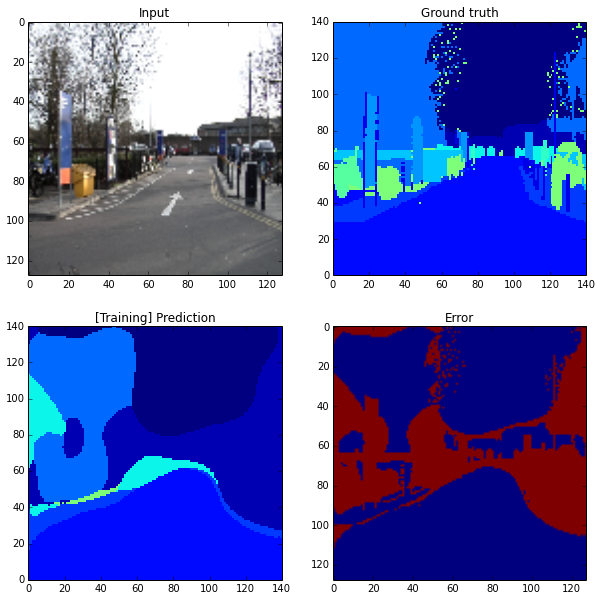

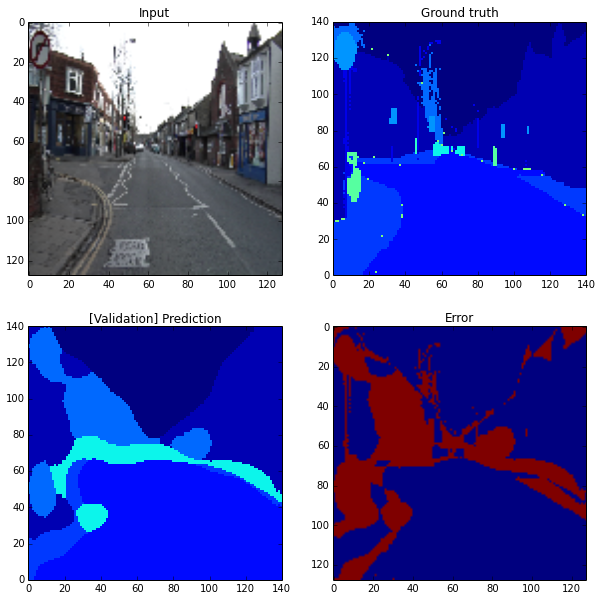

[121/1000] trainLoss: 0.9312 trainAcc: 0.78 valLoss: 1.1476 valAcc: 0.69
[122/1000] trainLoss: 0.9355 trainAcc: 0.78 valLoss: 1.1555 valAcc: 0.69
[123/1000] trainLoss: 0.9112 trainAcc: 0.79 valLoss: 1.1640 valAcc: 0.69
[124/1000] trainLoss: 0.9230 trainAcc: 0.78 valLoss: 1.1433 valAcc: 0.69
[125/1000] trainLoss: 0.9166 trainAcc: 0.78 valLoss: 1.1466 valAcc: 0.69
[126/1000] trainLoss: 0.9129 trainAcc: 0.78 valLoss: 1.1468 valAcc: 0.69
[127/1000] trainLoss: 0.8837 trainAcc: 0.79 valLoss: 1.1397 valAcc: 0.69
[128/1000] trainLoss: 0.9073 trainAcc: 0.79 valLoss: 1.1307 valAcc: 0.69
[129/1000] trainLoss: 0.9067 trainAcc: 0.78 valLoss: 1.1316 valAcc: 0.69
[130/1000] trainLoss: 0.8985 trainAcc: 0.79 valLoss: 1.1273 valAcc: 0.69


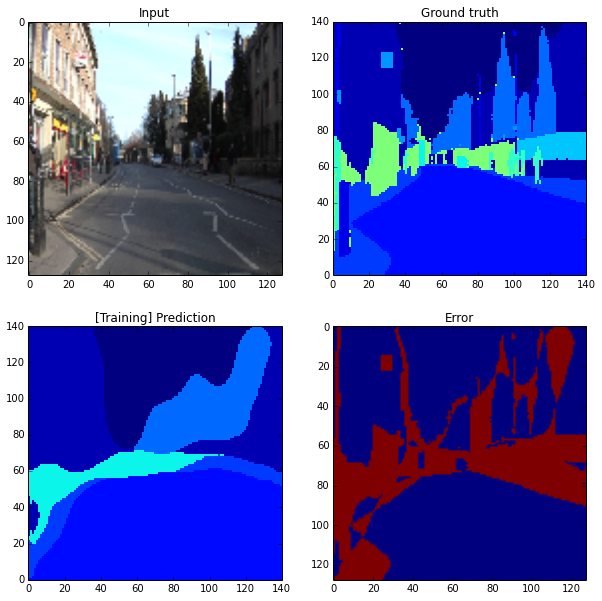

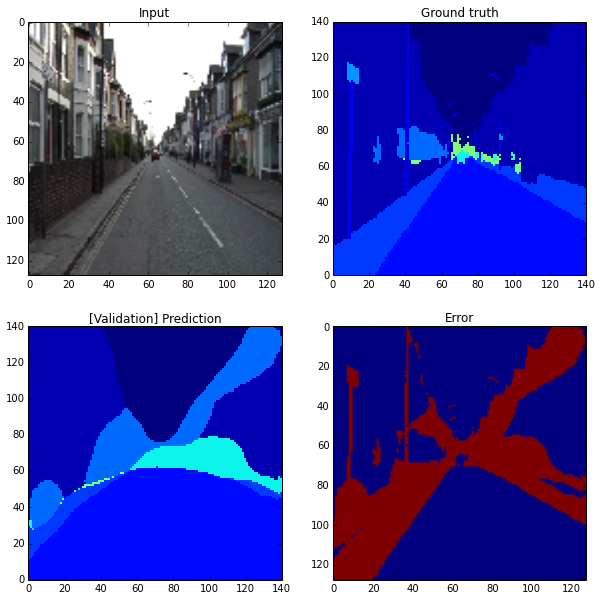

[131/1000] trainLoss: 0.8872 trainAcc: 0.79 valLoss: 1.1231 valAcc: 0.70
[132/1000] trainLoss: 0.8890 trainAcc: 0.79 valLoss: 1.1273 valAcc: 0.69
[133/1000] trainLoss: 0.8764 trainAcc: 0.79 valLoss: 1.1283 valAcc: 0.69
[134/1000] trainLoss: 0.8799 trainAcc: 0.79 valLoss: 1.1187 valAcc: 0.69
[135/1000] trainLoss: 0.8992 trainAcc: 0.78 valLoss: 1.1060 valAcc: 0.70
[136/1000] trainLoss: 0.8875 trainAcc: 0.79 valLoss: 1.1078 valAcc: 0.70


In [ ]:
resumeTraining = True
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()
    saver = tf.train.Saver()
    checkpoint = tf.train.latest_checkpoint("nets/semseg_basic")
    print ("checkpoint: %s" % (checkpoint))
    if resumeTraining == False:
        print "Start from scratch"
    elif  checkpoint:
        print "Restoring from checkpoint", checkpoint
        saver.restore(sess, checkpoint)
    else:
        print "Couldn't find checkpoint to restore from. Starting over."
    
    for epoch_i in range(n_epochs):
        trainLoss = []; trainAcc = []
        num_batch = int(ntrain/batch_size)+1
        for _ in range(num_batch):
            randidx = np.random.randint(ntrain, size=batch_size)
            batchData = trainData[randidx]
            batchLabel = trainLabelOneHot[randidx]
            sess.run(optm, feed_dict={x: batchData, y: batchLabel, keepprob: 0.7}) # <== Optm is done here!
            trainLoss.append(sess.run(cost, feed_dict={x: batchData, y: batchLabel, keepprob: 1.}))
            trainAcc.append(sess.run(accr, feed_dict={x: batchData, y: batchLabel, keepprob: 1.}))
        # Average loss and accuracy
        trainLoss = np.mean(trainLoss)
        trainAcc = np.mean(trainAcc)
        # Run test
        valLoss = sess.run(cost, feed_dict={x: testData, y: testLabelOneHot, keepprob: 1.})
        valAcc = sess.run(accr, feed_dict={x: testData, y: testLabelOneHot, keepprob: 1.})
        print ("[%02d/%02d] trainLoss: %.4f trainAcc: %.2f valLoss: %.4f valAcc: %.2f" 
               % (epoch_i, n_epochs, trainLoss, trainAcc, valLoss, valAcc))
        # Save snapshot
        if resumeTraining and epoch_i % 10 == 0:
            # Save
            saver.save(sess, 'nets/semseg_basic/progress', global_step = epoch_i)
            # Train data
            index = np.random.randint(trainData.shape[0])
            refimg = trainData[index, :, :, :].reshape(height, width, 3)
            batchData = trainData[index:index+1]
            batchLabel = trainLabelOneHot[index:index+1]
            predMaxOut = sess.run(predmax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            yMaxOut = sess.run(ymax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            gtimg = yMaxOut[0, :, :].reshape(height, width)
            errimg = gtimg - predMaxOut[0, :, :].reshape(height, width);
            # Plot
            xs = np.linspace(0, 140, 128); ys = np.linspace(140, 0, 128)
            plt.figure(figsize=(10, 10)) 
            plt.subplot(2, 2, 1); plt.imshow(refimg); plt.title('Input')
            plt.subplot(2, 2, 2); plt.pcolor(xs, ys, gtimg, vmin=0, vmax=nrclass); plt.title('Ground truth')
            plt.subplot(2, 2, 3); plt.pcolor(xs, ys, predMaxOut[0, :, :].reshape(height, width), vmin=0, vmax=nrclass); plt.title('[Training] Prediction')
            plt.subplot(2, 2, 4); plt.imshow(np.abs(errimg) > 0.5); plt.title('Error')
            plt.show() 
            # Test data
            index = np.random.randint(testData.shape[0])
            batchData = testData[index:index+1]
            batchLabel = testLabelOneHot[index:index+1]
            predMaxOut = sess.run(predmax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            yMaxOut = sess.run(ymax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            refimg = testData[index, :, :, :].reshape(height, width, 3)
            gtimg = yMaxOut[0, :, :].reshape(height, width)
            errimg = gtimg - predMaxOut[0, :, :].reshape(height, width)
            # Plot
            plt.figure(figsize=(10, 10)) 
            plt.subplot(2, 2, 1); plt.imshow(refimg); plt.title('Input')
            plt.subplot(2, 2, 2); plt.pcolor(xs, ys, gtimg, vmin=0, vmax=nrclass);  plt.title('Ground truth')
            plt.subplot(2, 2, 3); plt.pcolor(xs, ys, predMaxOut[0, :, :].reshape(height, width), vmin=0, vmax=nrclass); plt.title('[Validation] Prediction')
            plt.subplot(2, 2, 4); plt.imshow(np.abs(errimg) > 0.5); plt.title('Error')
            plt.show()

print ("Done")